# Симулятор азартной игры в стиле crash game.

## Правила
 - Игрок делает **ставку** любой суммы на случайный **множитель** от 1.1 до 50.
 - Выпадает случайный **множитель** число от 0 до 50.
 - С вероятностью **zerosratio** игрок не получает вообще ничего. множитель = 0. Пусть zerosratio = 0.13 .
 - Вероятность выпадения выигрыша обратно пропорциональна его множителю. Но, поскольку это множитель, то вероятность нелинейно пропорциональна, а обратно экспонентциально пропорциональна. То есть, распределение множителей соответствует так называемому **экспонентциальному** распределению.
 - Играем всегда фиксированное число ходов. Игра не прекращается если деньги закончились. Если сумма денег отрицательна - это просто долг игрока. Исследовать нужно и эти случаи тоже.

## Цель
 Выработать выигрышную стратегию

## Передположение психологического характера
 Если все игроки склонны ставить  повышенные ставки, то организатор сосредоточен на получении прибыли от них. 
 Тогда игрок обладающий достаточным терпением и суммой, может оказаться в выигрыше.

In [1]:
# набор стандартных библиотек для python
import pandas as pd
import numpy as np
import numba
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import njit, jit
from numpy.random import exponential
from typing import Callable # 

In [2]:
zerosratio=0.13

# Boostrap 
В этой версии не используется генератор случайных чисел.
Загружаем собранные данные из файла и формируем  из них последовательности желаемого размера. 

In [3]:
df=pd.read_csv('crash_data.tsv', sep='\t',header=None, names=['timestamp','point'],parse_dates= [0],dayfirst=True)
df.dtypes

timestamp    datetime64[ns]
point               float64
dtype: object

In [4]:
df.head(3)

,timestamp,point
0,2023-03-01 01:27:30,9.17
1,2023-03-01 01:27:38,0.00
2,2023-03-01 01:27:59,4.61


In [5]:
def mult_values(zerosratio: float, size: int) -> np.ndarray:
    return df.point.sample(size,replace=True).to_numpy() 

mult_values(0.13,5)

array([0.  , 1.6 , 5.29, 0.  , 2.39])

In [6]:
rvalues = mult_values(0.13,1000)
rvalues[:10]

array([8.56, 1.41, 2.49, 3.55, 4.69, 1.06, 1.14, 6.96, 1.2 , 5.54])

Проверим правдоподобность **данных** в помощью гистограммы распределений

<AxesSubplot: >

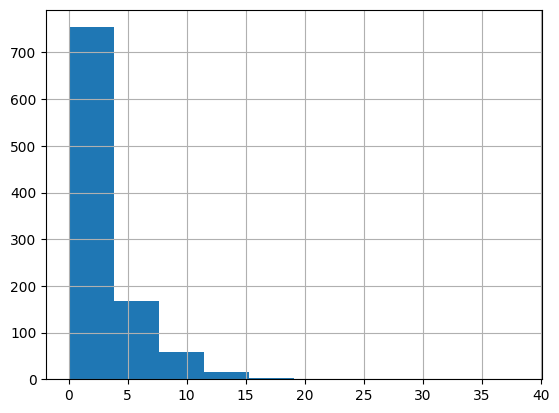

In [7]:
s = pd.Series(rvalues)
s.hist(bins=10)

In [8]:
# Старая функция с аналитическими коээфициентами:
#@jit
def mult_values_analitics(zerosratio: float,size: int) -> np.ndarray :
    zeros_values = np.zeros(round(size*zerosratio))
    exp_values = 1+np.random.exponential(scale=2.0, size=round((1-zerosratio)*size))
    result = np.concatenate((zeros_values, exp_values), axis=None)
    result = np.around(result,2)
    np.random.shuffle(result)
    return result

<AxesSubplot: >

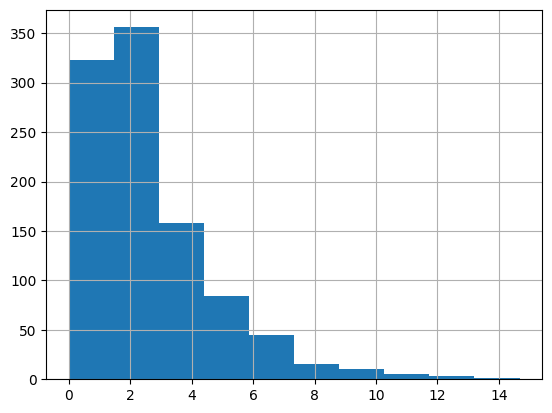

In [9]:
rvalues_analitics = mult_values_analitics(0.13,1000)
s2 = pd.Series(rvalues_analitics)
s2.hist(bins=10)

*Задание со звездочкой  : 
перерисовать гистограмму в логарифмической шкале. Сделать выводы. 
Получится прямая ?*
        

# Проверка различных стратегий

Все стратегии проверяются схожими по структуре функциями:

    - на вход подается массив исходов
    - на выходе массив возможных исходов

## Стратегия: постоянная ставка на некий коэффициент
Просто ставим 100  руб на постоянный коээфициент K передаваемый как аргумент

In [10]:
@njit
def strategy_const_k (balance: float, k: float)  -> float:
    return k

Разовая симуляция для отладки (и вообще-то в numba хотя бы раз вызвать функцию для компиляции).

Теперь эта функция поддерживает выход из игры с помощью исключений.
Конечно, это провальная идея, но все равно необходим эксперимент чтобы ее подтвердить.

In [11]:
start_balance = 5000.0
game_rounds = 100 # продолжительность серии игры
rvalues = mult_values(0.13,game_rounds)
k=2.7

@njit
def simulate_one_game(strategy: Callable, start_balance: float, sequence: np.ndarray) -> float:
    balance = start_balance
    bet = 100 # постоянная сумма ставки 
    bet_rate = strategy_const_k(balance,k) # постоянная стратегия
    for outcome  in sequence:
        balance = balance - bet
        #print('prev:',balance,' ',end='')
        if outcome >= bet_rate and outcome >= 1.1 :
            balance += bet * bet_rate
        #print('outcome',outcome, 'new balance',balance)
    return balance

total = simulate_one_game(strategy_const_k,start_balance,rvalues)
print(total)

6070.0


Серия симуляций для выяснения **распределения** прогнозируемой суммы. 

In [12]:
game_rounds = 1000 # число подходов в одной игре, раз.
number_of_games = 10000 # число симуляций
game_results = np.zeros(number_of_games)
k=2.7

#@jit
def simulate_all_games ():
    for i in range(number_of_games):
        rvalues = mult_values(0.13,game_rounds)
        game_results[i]=simulate_one_game(strategy_const_k,5000,rvalues)

simulate_all_games()
# Контроль первых 10 результатов 
game_results[1:10]

array([ 8950.,  7330.,  5980.,  3820.,  6790., 15430.,  3010.,  6250.,
        4900.])

Теперь можно рассуждать об перспективах в игре с учетом **number_of_games** равновозможных вариантов будущего.

Ожидаемая сумма распределиться по этому графику:

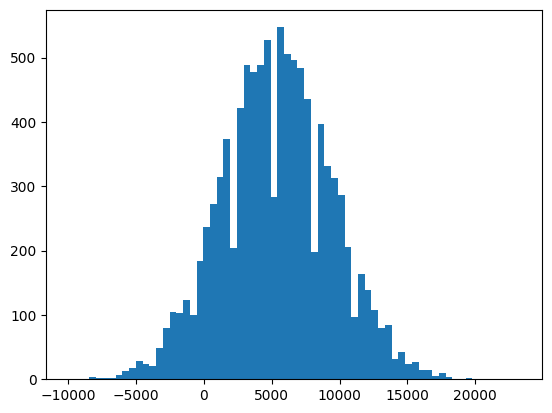

In [13]:
plt.hist(game_results,bins='auto');

In [14]:
print('Начали с ', start_balance, '. В среднем ожидаем выиграть', game_results.mean(), 
      ', но разброс +-',game_results.std())

Начали с  5000.0 . В среднем ожидаем выиграть 5391.211 , но разброс +- 4061.089445392578


# Поиск оптимального коэффициента 
Используем стандартные функцию scipy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar

In [15]:
from scipy.optimize import minimize_scalar

In [16]:
def find_function(x):
    # меняем глобальную k и перезапускам старую функцию
    k=x
    simulate_all_games()
    return -game_results.mean()

In [18]:
res = minimize_scalar(find_function, 1.5, bounds=(1.01, 500.0), method='bounded')
res

 message: Solution found.
 success: True
  status: 0
     fun: -5451.61
       x: 25.871834996106024
     nit: 34
    nfev: 34

Непонятный результат. Вероятно, функция просто не имеет горба, а сильно случайна и исход не зависит от коээфициента